In [1]:
%matplotlib notebook


In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
from datetime import datetime
from sklearn_pandas import DataFrameMapper
import warnings

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## TODO: read files for 2011-2015 as train, and 2016 as test

In [3]:
NAMES = ('WBAN_number', 'UTC_date', 'UTC_time', 'LST_date', 'LST_time', 'CRX_version',
        'longitude', 'latitude', 'air_temperature', 'precepitation', 'solar_radiation',
        'SR_flag', 'surface_temperature', 'ST_type', 'ST_flag', 'relative_humidity', 'RH_flag',
        'soil_moisture', 'soil_temperature', 'wetness', 'wet_flag', 'wind', 'wind_flag')

TRAIN_YEARS = range(2011, 2015)
VALIDATION_YEAR = 2015
TEST_YEAR = 2016
FILENAME_FORMAT = './data/yosemite_village/CRNS0101-05-{year}-CA_Yosemite_Village_12_W.txt'

train_temperature_data = pandas.concat([pandas.read_table(FILENAME_FORMAT.format(year=year),
                                                          sep=r'\s+', header=None, names=NAMES)
                                       for year in TRAIN_YEARS])

print(train_temperature_data.shape)
train_temperature_data.head()

(420768, 23)


,WBAN_number,UTC_date,UTC_time,LST_date,LST_time,CRX_version,longitude,latitude,air_temperature,precepitation,...,ST_type,ST_flag,relative_humidity,RH_flag,soil_moisture,soil_temperature,wetness,wet_flag,wind,wind_flag
0,53150,20110101,5,20101231,1605,2,-119.82,37.76,-6.4,0.0,...,U,0,-9999,0,-99.0,-9999.0,1218,0,-99.0,0
1,53150,20110101,10,20101231,1610,2,-119.82,37.76,-6.5,0.0,...,U,0,-9999,0,-99.0,-9999.0,1223,0,-99.0,0
2,53150,20110101,15,20101231,1615,2,-119.82,37.76,-6.5,0.0,...,U,0,-9999,0,-99.0,-9999.0,1223,0,-99.0,0
3,53150,20110101,20,20101231,1620,2,-119.82,37.76,-6.5,0.0,...,U,0,-9999,0,-99.0,-9999.0,1224,0,-99.0,0
4,53150,20110101,25,20101231,1625,2,-119.82,37.76,-6.7,0.0,...,U,0,-9999,0,-99.0,-9999.0,1210,0,-99.0,0


In [4]:
validation_temperature_data = pandas.read_table(FILENAME_FORMAT.format(year=VALIDATION_YEAR),
                                          sep=r'\s+', header=None, names=NAMES)
print(validation_temperature_data.shape)

test_temperature_data = pandas.read_table(FILENAME_FORMAT.format(year=TEST_YEAR),
                                          sep=r'\s+', header=None, names=NAMES)
print(test_temperature_data.shape)

(105120, 23)
(105408, 23)


## Parse only the fields we care about, and clear out NAs
The documentation says -9999 are their NA representation, so we substitute None and drop NAs

In [5]:
TEMPERATURE_PREDICTION_FIELDS = ('LST_date', 'LST_time', 'air_temperature')

limited_train = train_temperature_data.loc[:,TEMPERATURE_PREDICTION_FIELDS]
print(limited_train.shape)
limited_train = limited_train.replace({-9999.0: None}).dropna()
print(limited_train.shape)

limited_validation = validation_temperature_data.loc[:,TEMPERATURE_PREDICTION_FIELDS]
print(limited_validation.shape)
limited_validation = limited_validation.replace({-9999.0: None}).dropna()
print(limited_validation.shape)

limited_test = test_temperature_data.loc[:,TEMPERATURE_PREDICTION_FIELDS]
print(limited_test.shape)
limited_test = limited_test.replace({-9999.0: None}).dropna()
print(limited_test.shape)

(420768, 3)
(420417, 3)
(105120, 3)
(105063, 3)
(105408, 3)
(105374, 3)


## Examine the field we wish to predict, making sure it is reasonably well-behaved

<IPython.core.display.Javascript object>


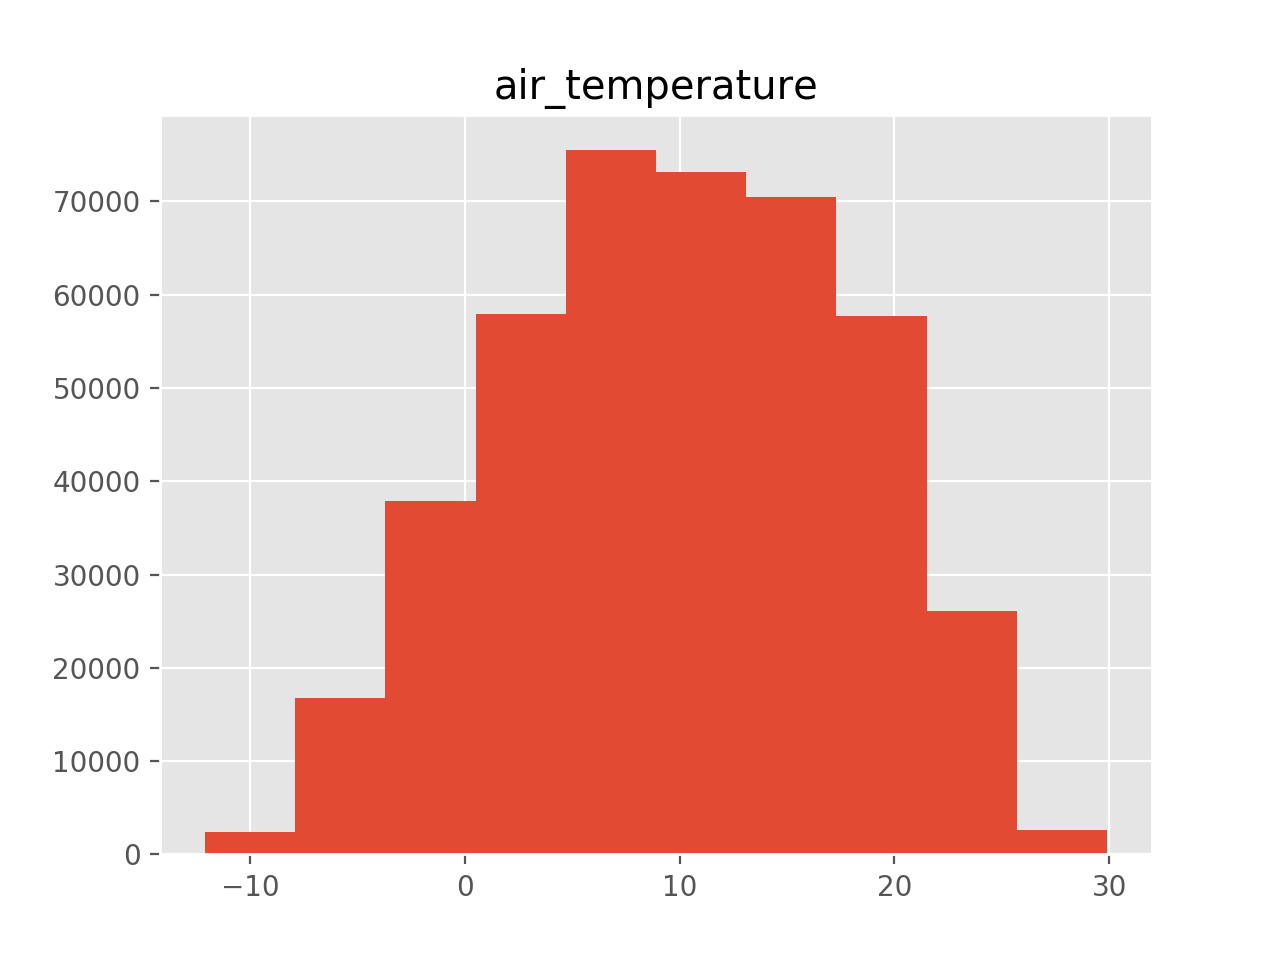

<IPython.core.display.Javascript object>


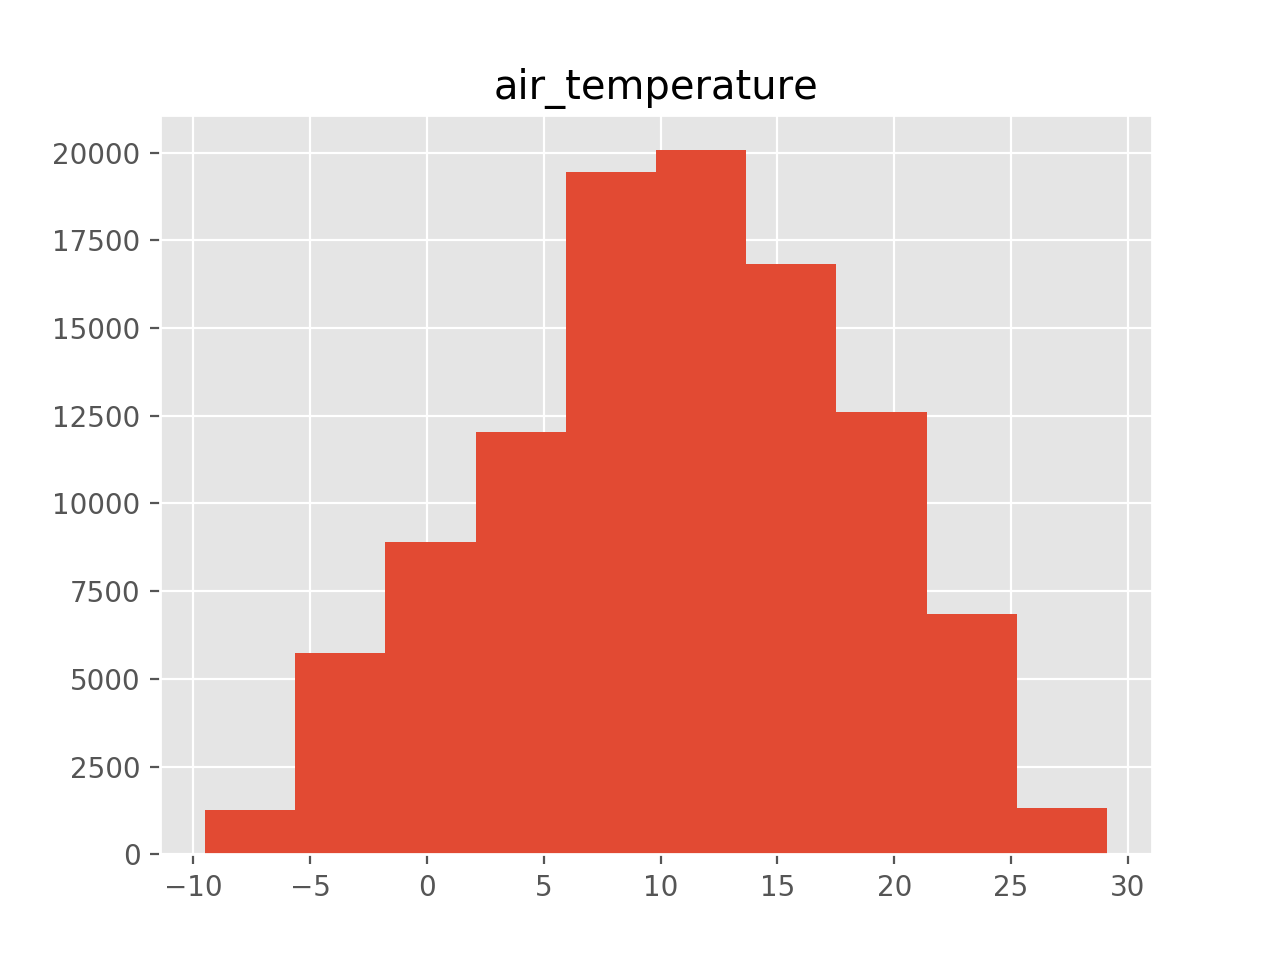

<IPython.core.display.Javascript object>


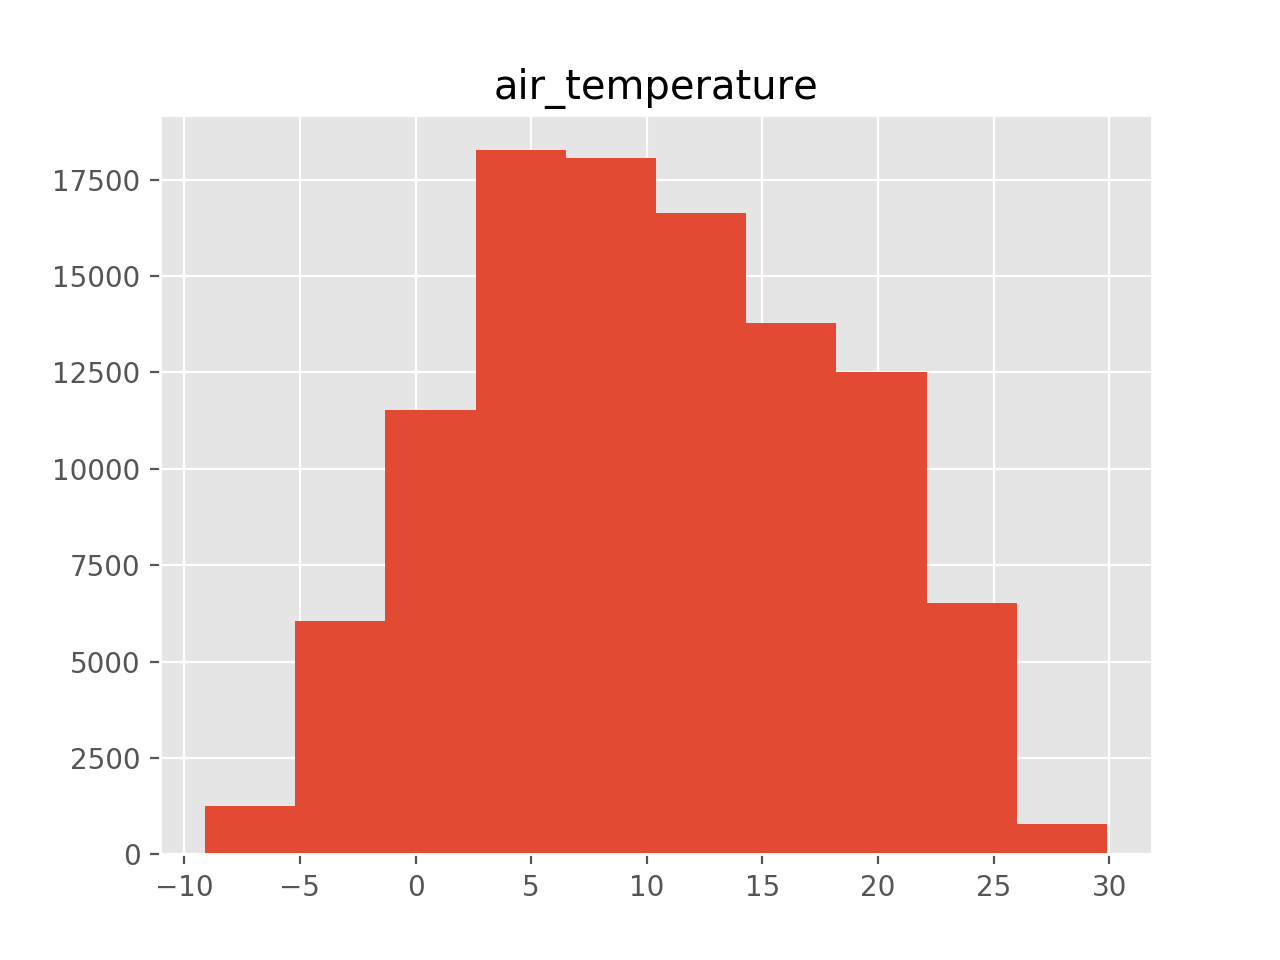

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116909978>]], dtype=object)

In [6]:
limited_train.hist('air_temperature')
limited_validation.hist('air_temperature')
limited_test.hist('air_temperature')

## Parse date to day of year, time to minute of day

In [7]:
DATE_FORMAT = '%Y%m%d'

for dataset in (limited_train, limited_validation, limited_test):
    dataset['LST_day_of_year'] = [datetime.strptime(str(lst_date), DATE_FORMAT).timetuple().tm_yday
                                  for lst_date in dataset.LST_date]

    dataset['LST_time_of_day'] = [lst_time if lst_time < 100 
                                  else int((lst_time % 100) + np.floor(lst_time / 100) * 60)
                                  for lst_time in dataset.LST_time]

## Defining a transformed to apply a pre-provided RBF

In [117]:
from sklearn.base import TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

class RBFEncoder(TransformerMixin):
    def __init__(self, means, alpha):
        self.means = means if type(means) in (np.array, np.ndarray) else np.array(means).reshape((-1, 1))
        self.alpha = alpha
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # np.exp(- 1 / (2 * self.alpha ** 2) * (X - self.m) ** 2)
#         X = X.reshape(-1, 1)
        return rbf_kernel(X, self.means, gamma=1 / (2 * self.alpha ** 2))

## Seasonal variation (1)
From https://www.nps.gov/yose/planyourvisit/weather.htm

The temperature peak appears to be in July/August, and the trough in December/January, so we can start by computing features as distance within the year from each (day 0, day 212, day 365). We can do something similar with the time of day later.

The hottest time of the day appears to be around 1500 or so.

In [118]:
DAY_MEANS = (0, 212, 365)
DAY_ALPHA = 70
TIME_MEANS = (0, 900, 1440)
TIME_ALPHA = 400


data_mapper = DataFrameMapper([
    (['LST_day_of_year'], RBFEncoder(DAY_MEANS, DAY_ALPHA)),
    (['LST_time_of_day'], RBFEncoder(TIME_MEANS, TIME_ALPHA)),
])

transformed_train = data_mapper.fit_transform(limited_train.copy())
print(transformed_train.shape)
transformed_train[:5]

(420417, 6)


array([[  1.24747661e-06,   9.17513141e-02,   1.00000000e+00,
          5.44714741e-02,   9.86883654e-01,   4.94069974e-01],
       [  1.24747661e-06,   9.17513141e-02,   1.00000000e+00,
          5.28492108e-02,   9.84804140e-01,   5.01419351e-01],
       [  1.24747661e-06,   9.17513141e-02,   1.00000000e+00,
          5.12672504e-02,   9.82575469e-01,   5.08798546e-01],
       [  1.24747661e-06,   9.17513141e-02,   1.00000000e+00,
          4.97248734e-02,   9.80198673e-01,   5.16205674e-01],
       [  1.24747661e-06,   9.17513141e-02,   1.00000000e+00,
          4.82213637e-02,   9.77674853e-01,   5.23638811e-01]])

## Use the transformation defined above to model temperature (2)

In [100]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV

np.random.seed(33)


pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper),
    ('ridge', RidgeCV()),
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    shuffled = limited_train.sample(frac=1)
    cv_scores = np.round(cross_val_score(pipe, X=shuffled, y=shuffled.air_temperature, 
                                         scoring='mean_squared_error', cv=5), 3)
    print(np.average(cv_scores), cv_scores)
    
#     for k in range(3, 16):
#         pipe.set_params(select__k=k)
#         shuffled = data_train.sample(frac=1)
#         cv_scores = np.round(cross_val_score(pipe, X=shuffled, y=shuffled.like, scoring='r2', cv=7), 3)
#         print(k, np.average(cv_scores), cv_scores)

-24.375 [-24.449 -24.353 -24.407 -24.298 -24.368]


In [101]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

shuffled = limited_train.sample(frac=1)
pipe.fit(shuffled, shuffled.air_temperature)

validation_predictions = pipe.predict(limited_validation)

for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
               metrics.median_absolute_error, metrics.r2_score): 
    print(metric.__name__, metric(validation_predictions, limited_validation.air_temperature))

mean_squared_error 25.5736733178
mean_absolute_error 4.20662533437
median_absolute_error 3.84212226221
r2_score 0.324454703763


## Plotting different contributions (3)
Under this model, the first three components are the day of year contributions, and the latter three are the time of day, so we can separate them out

Plotting the validation set since it's less massive than the training set

In [12]:
ridge = pipe.steps[1][1]
day_of_year_coef = ridge.coef_[:3]
time_of_day_coef = ridge.coef_[3:]

transformed_validation = data_mapper.transform(limited_validation)

temperature_day_contrib = np.matmul(transformed_validation[:,:3], day_of_year_coef)
temperature_time_contrib = np.matmul(transformed_validation[:,3:], time_of_day_coef)

In [16]:
def plot_contributions(x, y, label):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=5, label=label)
    plt.legend(loc=1, fontsize=16)
    plt.xlabel(label, size=16)
    plt.ylabel(r'Predicted temperatire', size=16)
    plt.show()

<IPython.core.display.Javascript object>


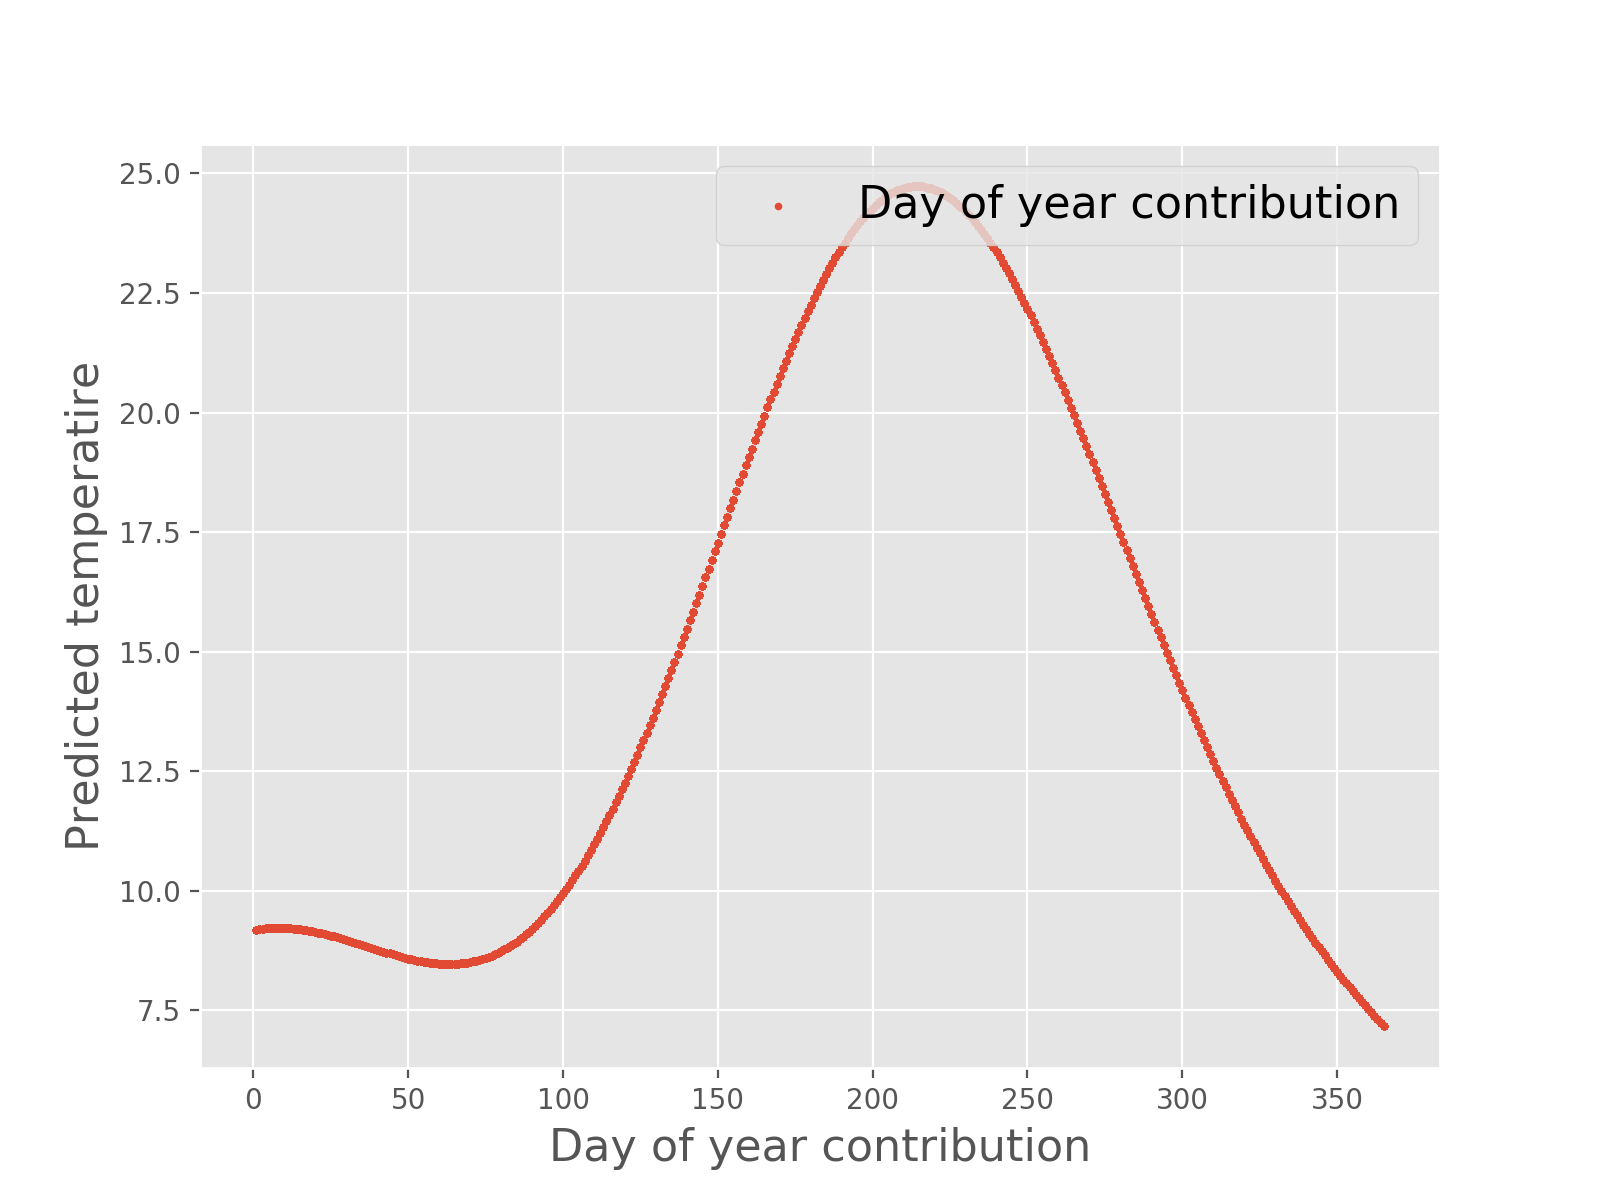

<IPython.core.display.Javascript object>


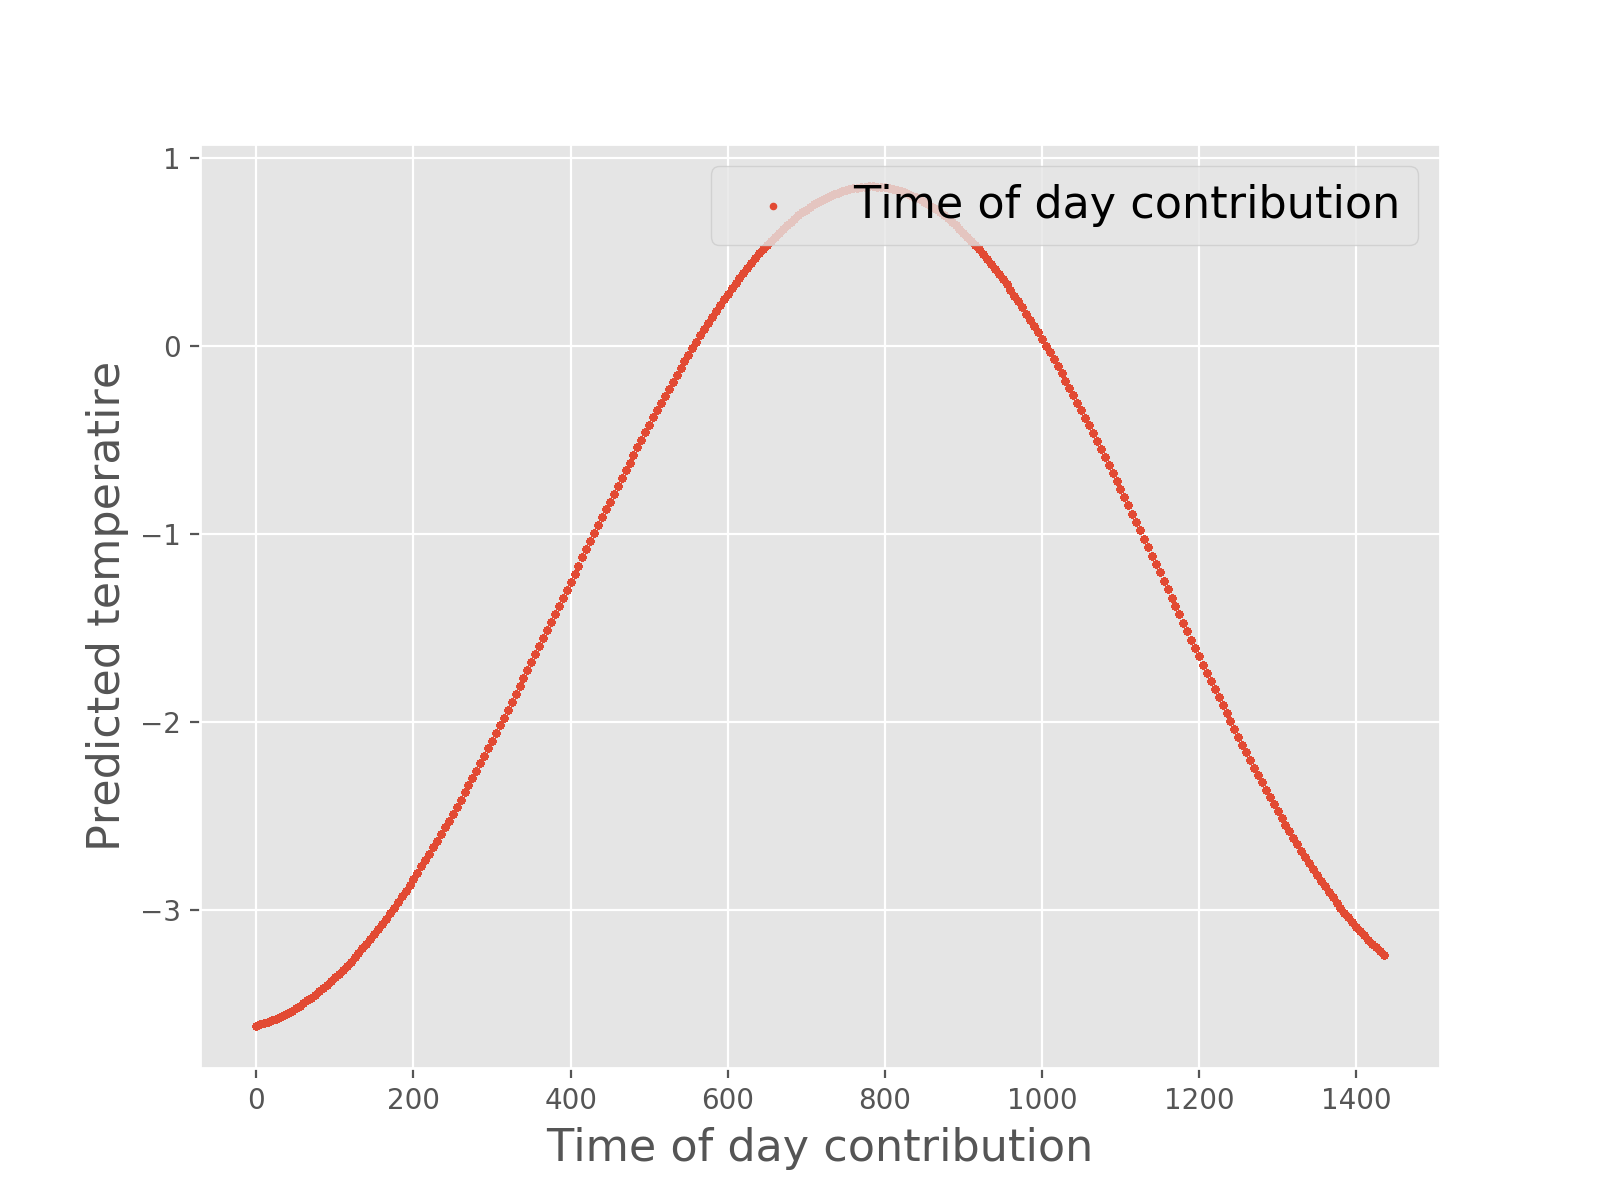

In [17]:
plot_contributions(limited_validation.LST_day_of_year, temperature_day_contrib, 'Day of year contribution')
plot_contributions(limited_validation.LST_time_of_day, temperature_time_contrib, 'Time of day contribution')

## 3-d plot of both time of day and day of year contributions (4)

The color mapping is designed to (maybe?) help understand where the model is over-predicting and where it is under-predicting. I color by the difference between the actual observed temperature and the prediction, coloring red when the actual observed temperature was hotter, white when they're about the same, and blue when the observed temperature was colder.

<IPython.core.display.Javascript object>


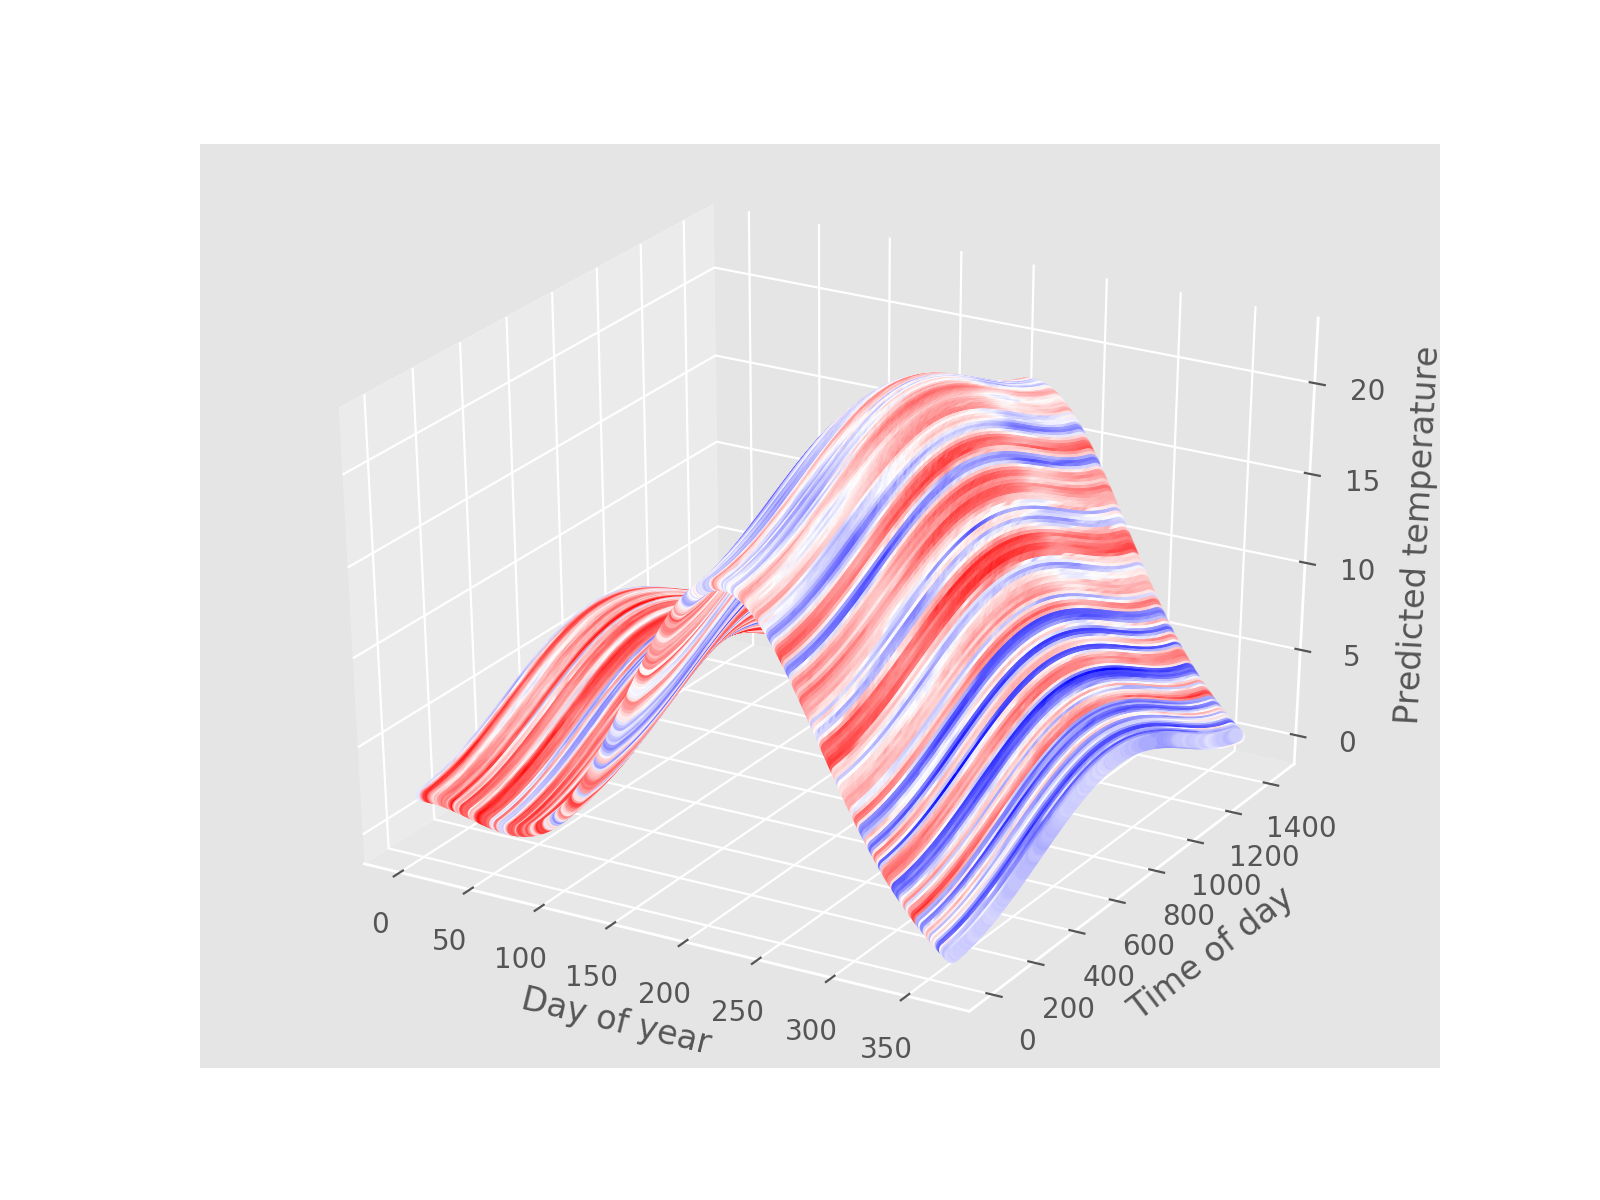

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(limited_validation.LST_day_of_year, limited_validation.LST_time_of_day,
          validation_predictions, c=limited_validation.air_temperature - validation_predictions,
          cmap='bwr')

ax.set_xlabel('Day of year', size=12)
ax.set_ylabel('Time of day', size=12)
ax.set_zlabel('Predicted temperature', size=12)

## Let's comapre time-only and day-only models to above performance (5.1, 5.2)

In [102]:
DAY_MEANS = (0, 212, 365)
DAY_ALPHA = 70
TIME_MEANS = (0, 900, 1440)
TIME_ALPHA = 400


day_only_data_mapper = DataFrameMapper([
    (['LST_day_of_year'], RBFEncoder(DAY_MEANS, DAY_ALPHA)),
])

time_only_data_mapper = DataFrameMapper([
    (['LST_time_of_day'], RBFEncoder(TIME_MEANS, TIME_ALPHA)),
])

day_only_data_mapper.fit_transform(limited_train.copy())
time_only_data_mapper.fit_transform(limited_train.copy())


array([[ 0.05447147,  0.98688365,  0.49406997],
       [ 0.05284921,  0.98480414,  0.50141935],
       [ 0.05126725,  0.98257547,  0.50879855],
       ..., 
       [ 0.05958732,  0.99221794,  0.47221896],
       [ 0.0578398 ,  0.99059142,  0.479468  ],
       [ 0.05613476,  0.98881304,  0.48675226]])

In [23]:
np.random.seed(RANDOM_SEED)

day_only_pipe = sklearn.pipeline.Pipeline([
    ('featurize', day_only_data_mapper),
    ('ridge', RidgeCV()),
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    shuffled = limited_train.sample(frac=1)
    cv_scores = np.round(cross_val_score(day_only_pipe, X=shuffled, y=shuffled.air_temperature, 
                                         scoring='mean_squared_error', cv=5), 3)
    print(np.average(cv_scores), cv_scores)

    
shuffled = limited_train.sample(frac=1)
day_only_pipe.fit(shuffled, shuffled.air_temperature)

day_only_validation_predictions = day_only_pipe.predict(limited_validation)

for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
               metrics.median_absolute_error, metrics.r2_score): 
    print(metric.__name__, metric(day_only_validation_predictions, limited_validation.air_temperature))

-26.579 [-26.613 -26.546 -26.687 -26.481 -26.568]
mean_squared_error 28.0590404039
mean_absolute_error 4.3980149437
median_absolute_error 4.03802355552
r2_score 0.21269101949


In [25]:
np.random.seed(RANDOM_SEED)

time_only_pipe = sklearn.pipeline.Pipeline([
    ('featurize', time_only_data_mapper),
    ('ridge', RidgeCV()),
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    shuffled = limited_train.sample(frac=1)
    cv_scores = np.round(cross_val_score(time_only_pipe, X=shuffled, y=shuffled.air_temperature, 
                                         scoring='mean_squared_error', cv=5), 3)
    print(np.average(cv_scores), cv_scores)

    
shuffled = limited_train.sample(frac=1)
time_only_pipe.fit(shuffled, shuffled.air_temperature)

time_only_validation_predictions = time_only_pipe.predict(limited_validation)

for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
               metrics.median_absolute_error, metrics.r2_score): 
    print(metric.__name__, metric(time_only_validation_predictions, limited_validation.air_temperature))

-60.0238 [-60.028 -60.442 -59.98  -59.861 -59.808]
mean_squared_error 55.0397262137
mean_absolute_error 6.05221746777
median_absolute_error 5.34623313466
r2_score -24.1436650411


## (5) Conclusion 

The day-only model captures most of the variation, ending with a fairly close MSE to the full model (validation MSE of 28.06, compared to 25.57 for the fully-blown model). On the other hand, the time-of-day model fares miserably, showing an MSE of almost twice as much as the other two, at 55.04 on the validation set.

This makes sense with our first-order understanding of the world; temperature varies by season much more strongly than it varies by the time of day.

## Let's try with a higher number of less-well-engineered basis functions

In [103]:
DAY_MEANS = (0, 61, 122, 183, 244, 365)
DAY_ALPHA = 40
TIME_MEANS = (0, 240, 480, 720, 960, 1200, 1440)
TIME_ALPHA = 100

more_bases_data_mapper = DataFrameMapper([
    (['LST_day_of_year'], RBFEncoder(DAY_MEANS, DAY_ALPHA)),
    (['LST_time_of_day'], RBFEncoder(TIME_MEANS, TIME_ALPHA)),
])

transformed_train = more_bases_data_mapper.fit_transform(limited_train.copy())
print(transformed_train.shape)
transformed_train[:5]

(420417, 13)


array([[  8.30040465e-19,   2.86797501e-13,   9.68378984e-09,
          3.19528238e-05,   1.03030790e-02,   1.00000000e+00,
          6.00766980e-21,   3.85654273e-12,   7.80106730e-06,
          4.97248734e-02,   9.98750781e-01,   6.32127031e-02,
          1.26071052e-05],
       [  8.30040465e-19,   2.86797501e-13,   9.68378984e-09,
          3.19528238e-05,   1.03030790e-02,   1.00000000e+00,
          3.70353198e-21,   2.68054764e-12,   6.11356797e-06,
          4.39369336e-02,   9.95012479e-01,   7.10053537e-02,
          1.59667839e-05],
       [  8.30040465e-19,   2.86797501e-13,   9.68378984e-09,
          3.19528238e-05,   1.03030790e-02,   1.00000000e+00,
          2.27740572e-21,   1.85850261e-12,   4.77913973e-06,
          3.87257704e-02,   9.88813045e-01,   7.95595087e-02,
          2.01712951e-05],
       [  8.30040465e-19,   2.86797501e-13,   9.68378984e-09,
          3.19528238e-05,   1.03030790e-02,   1.00000000e+00,
          1.39694394e-21,   1.28533723e-12,   3.726

In [104]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV

np.random.seed(33)

more_bases_pipe = sklearn.pipeline.Pipeline([
    ('featurize', more_bases_data_mapper),
    ('ridge', RidgeCV()),
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    shuffled = limited_train.sample(frac=1)
    cv_scores = np.round(cross_val_score(more_bases_pipe, X=shuffled, y=shuffled.air_temperature, 
                                         scoring='mean_squared_error', cv=5), 3)
    print(np.average(cv_scores), cv_scores)
    
#     for k in range(3, 16):
#         pipe.set_params(select__k=k)
#         shuffled = data_train.sample(frac=1)
#         cv_scores = np.round(cross_val_score(pipe, X=shuffled, y=shuffled.like, scoring='r2', cv=7), 3)
#         print(k, np.average(cv_scores), cv_scores)

-23.6812 [-23.759 -23.652 -23.684 -23.615 -23.696]


In [105]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

shuffled = limited_train.sample(frac=1)
more_bases_pipe.fit(shuffled, shuffled.air_temperature)

more_bases_validation_predictions = more_bases_pipe.predict(limited_validation)

for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
               metrics.median_absolute_error, metrics.r2_score): 
    print(metric.__name__, metric(more_bases_validation_predictions, 
                                  limited_validation.air_temperature))

mean_squared_error 25.5417811586
mean_absolute_error 4.18470465283
median_absolute_error 3.78349262737
r2_score 0.337450520671


## Adding more basis functions helps

Shcoking conclusion, truly. When you give a linear model more data, it does better... 

Let's do two things (one above, one below). 

Above, I'll add a validation set, using the 2015 data, to make sure the improvements are not training-only.

### Note: validation set performance looks identical (scarily so) between the two. Very weird.

Had I had more time, I would have liked to be more Bayesian about it. Perhaps use model evidence or something to make sure that I'm actually gaining performance from the additional bases. I'll have to see if I can get ridge models to give me evidence or BIC, or if not, try something else. The quick answer is that I cannot get the model evidence or BIC directly.

I'd also like to be searching over the different basis means, rather than hard-coding them, as if I can learn them from the data I should arrive at better results.

I'll try to fit a Gaussian mixture model using the dirichlet process below, and see if I can get some better idea for what sort of means I'd like to use. 

In [122]:
from sklearn.mixture import BayesianGaussianMixture

FIELDS = ('LST_day_of_year', 'LST_time_of_day', 'air_temperature')
mixture_train = limited_train.loc[:,FIELDS]

mixture = BayesianGaussianMixture(n_components=20, max_iter=1000, verbose=1)
mixture.fit(mixture_train)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
  Iteration 280
  Iteration 290
  Iteration 300
  Iteration 310
  Iteration 320
  Iteration 330
  Iteration 340
  Iteration 350
  Iteration 360
  Iteration 370
  Iteration 380
  Iteration 390
  Iteration 400
  Iteration 410
  Iteration 420
  Iteration 430
  Iteration 440
  Iteration 450
  Iteration 460
  Iteration 470
  Iteration 480
  Iteration 490
  Iteration 500
  Iteration 510
  Iteration 520
  Iteration 530
  Iteration 540
  Iteration 550
  Iteration 560
  Iteration 570
  Iteration 580
  Iteration 590
  Iteration 600
  Iteration 610
  

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=1000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=1, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [92]:
print(mixture.weights_)
day_and_time_means = mixture.means_[:,:2]
day_and_time_gamma_estimate = np.sqrt(np.mean(mixture.covariances_[:,:2,:2]))

[ 0.10021427  0.07385262  0.09487568  0.0474346   0.10244291  0.13702015
  0.10740243  0.10636883  0.12919334  0.10119517]


In [119]:
combined_data_mapper = DataFrameMapper([
    (['LST_day_of_year', 'LST_time_of_day'], RBFEncoder(day_and_time_means, day_and_time_gamma_estimate)),
])

combined_transformed_train = combined_data_mapper.fit_transform(limited_train.copy())
print(combined_transformed_train.shape)
combined_transformed_train[:5]

(420417, 10)


array([[  2.95748871e-01,   1.21309163e-03,   2.25483669e-01,
          2.44975242e-12,   4.98150835e-03,   1.93160253e-04,
          5.95314518e-03,   5.34381763e-11,   1.44345556e-02,
          3.17039966e-04],
       [  3.15137211e-01,   1.10395071e-03,   2.37851003e-01,
          1.79505444e-12,   4.54847568e-03,   1.61860871e-04,
          6.58415568e-03,   4.03818474e-11,   1.31766912e-02,
          2.68835591e-04],
       [  3.35184321e-01,   1.00279734e-03,   2.50439194e-01,
          1.31292667e-12,   4.14551325e-03,   1.35385887e-04,
          7.26877331e-03,   3.04598777e-11,   1.20065086e-02,
          2.27544809e-04],
       [  3.55856679e-01,   9.09251617e-04,   2.63212811e-01,
          9.58541081e-13,   3.77136142e-03,   1.13034843e-04,
          8.00994575e-03,   2.29338804e-11,   1.09202988e-02,
          1.92244763e-04],
       [  3.77115136e-01,   8.22929075e-04,   2.76133544e-01,
          6.98535382e-13,   3.42472275e-03,   9.42016894e-05,
          8.81059913e-03

In [121]:
np.random.seed(RANDOM_SEED)

combined_means_pipe = sklearn.pipeline.Pipeline([
    ('featurize', combined_data_mapper),
    ('ridge', RidgeCV()),
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    shuffled = limited_train.sample(frac=1)
    cv_scores = np.round(cross_val_score(combined_means_pipe, X=shuffled, y=shuffled.air_temperature, 
                                         scoring='mean_squared_error', cv=5), 3)
    print(np.average(cv_scores), cv_scores)

    
shuffled = limited_train.sample(frac=1)
combined_means_pipe.fit(shuffled, shuffled.air_temperature)

combined_validation_predictions = combined_means_pipe.predict(limited_validation)

for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
               metrics.median_absolute_error, metrics.r2_score): 
    print(metric.__name__, metric(combined_validation_predictions, limited_validation.air_temperature))

-44.7912 [-44.669 -44.935 -44.853 -44.805 -44.694]
mean_squared_error 45.5513348937
mean_absolute_error 5.47202028482
median_absolute_error 4.63598551456
r2_score -1.60905854576


## Running the first (simplest) model on the test set

In [123]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

shuffled = limited_train.sample(frac=1)
pipe.fit(shuffled, shuffled.air_temperature)

temperature_test_predictions = pipe.predict(limited_test)

for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
               metrics.median_absolute_error, metrics.r2_score): 
    print(metric.__name__, metric(temperature_test_predictions, limited_test.air_temperature))

mean_squared_error 22.3595903912
mean_absolute_error 3.91367291804
median_absolute_error 3.5469636433
r2_score 0.410237154857


The test MSE is even lower than the validation one. Cool!

# Classification problem - predict rainfall
Relevant fields:
* date and time, as parsed above, perhaps even with the basis functions
* air temperature (we ignore surface temperature as they're likely similar?)
* precipitation itself, which we need to convert to a binary indicator
* solar radiation
    * removing rows where sr_flag is not 0 (overflow or erroneous data)
* relative humidity, making sure it's not too strong a predictor (since rain might == 100% humidity?)
    * and similarly, removing rows where rh_flag is not 0
* soil_moisture, under the same note for relative humidity (if it's raining soil is bound to be moist?)
* by their definition, wetness is a very strong predictor for precipitation, which means that for the model to be useful we should probably omit it
* wind_1_5, the wind speed at 1.5
    * again, remove rows where wind_flag is not 0

In [26]:
RAINFALL_PREDICTION_FIELDS = ('LST_date', 'LST_time', 'air_temperature', 'precepitation',
                             'solar_radiation', 'SR_flag', 'relative_humidity', 'RH_flag',
                             'soil_moisture', 'wind', 'wind_flag')

rain_train = train_temperature_data.loc[:,RAINFALL_PREDICTION_FIELDS]
print(rain_train.shape)
rain_train = rain_train.replace({-9999.0: None}).dropna()
print(rain_train.shape)
for flag_field in ('SR_flag', 'RH_flag', 'wind_flag'):
    rain_train[flag_field] = rain_train[flag_field].replace({1: None, 3: None})
rain_train = rain_train.dropna()
print(rain_train.shape)
print()

rain_validation = validation_temperature_data.loc[:,RAINFALL_PREDICTION_FIELDS]
print(rain_validation.shape)
rain_validation = rain_validation.replace({-9999.0: None}).dropna()
print(rain_validation.shape)
for flag_field in ('SR_flag', 'RH_flag', 'wind_flag'):
    rain_validation[flag_field] = rain_validation[flag_field].replace({1: None, 3: None})
rain_validation = rain_validation.dropna()
print(rain_validation.shape)
print()

rain_test = test_temperature_data.loc[:,RAINFALL_PREDICTION_FIELDS]
print(rain_test.shape)
rain_test = rain_test.replace({-9999.0: None}).dropna()
print(rain_test.shape)
for flag_field in ('SR_flag', 'RH_flag', 'wind_flag'):
    rain_test[flag_field] = rain_test[flag_field].replace({1: None, 3: None})
rain_test = rain_test.dropna()
print(rain_test.shape)
print()


(420768, 11)
(364072, 11)
(364072, 11)

(105120, 11)
(105063, 11)
(105063, 11)

(105408, 11)
(105374, 11)
(105374, 11)



## Let's examine the covariance matrix quickly

Looking at the validation set, since it's smaller.

Plotting code inspired by https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap

Plotting the log-covariance with the original sign, to shrink the values a little. Not super useful, but still neat.

<IPython.core.display.Javascript object>


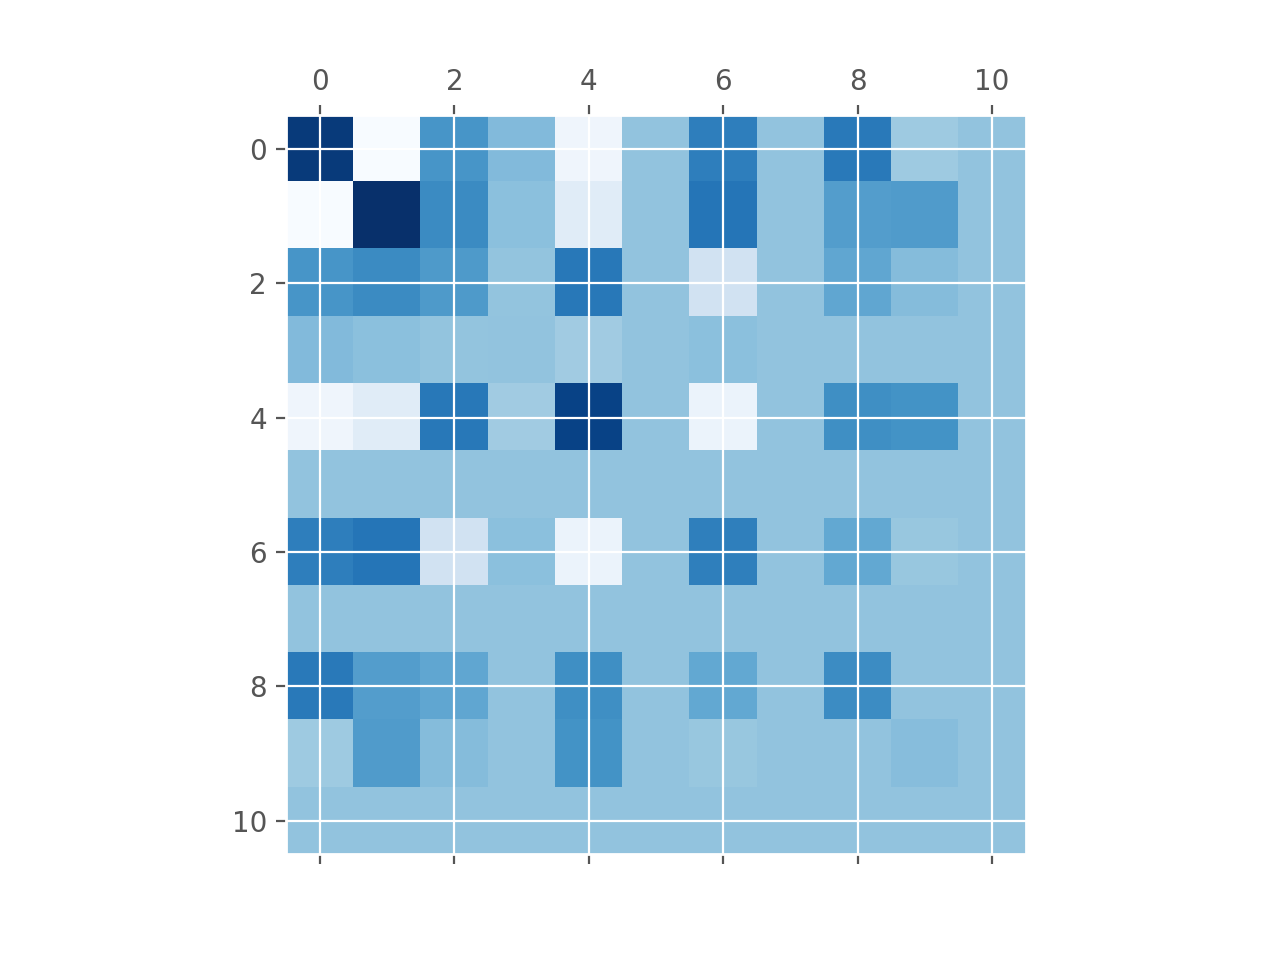

In [47]:
from sklearn.covariance import empirical_covariance

cov = empirical_covariance(rain_validation)
log_cov = np.log(np.abs(cov) + 1) * np.sign(cov)

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

min_val, max_val = np.min(log_cov), np.max(log_cov)

ax.matshow(log_cov, cmap=plt.cm.Blues)

# for i in range(log_cov.shape[1]):
#     for j in range(log_cov.shape[0]):
#         c = log_cov[j, i]
#         ax.text(i, j, str(c), va='center', ha='center')

## Let's plot precipitation to understand how I should binarize it

Do I even want to binarize it, though? That loses information, which is unfortunate (i.e. on a timestamp with more rain I'd want to predict rain with higher certainty?). Perhaps I'd rather regress linearly and then decide how to apply a non-linearity to transform to the range 0, 1?

<IPython.core.display.Javascript object>


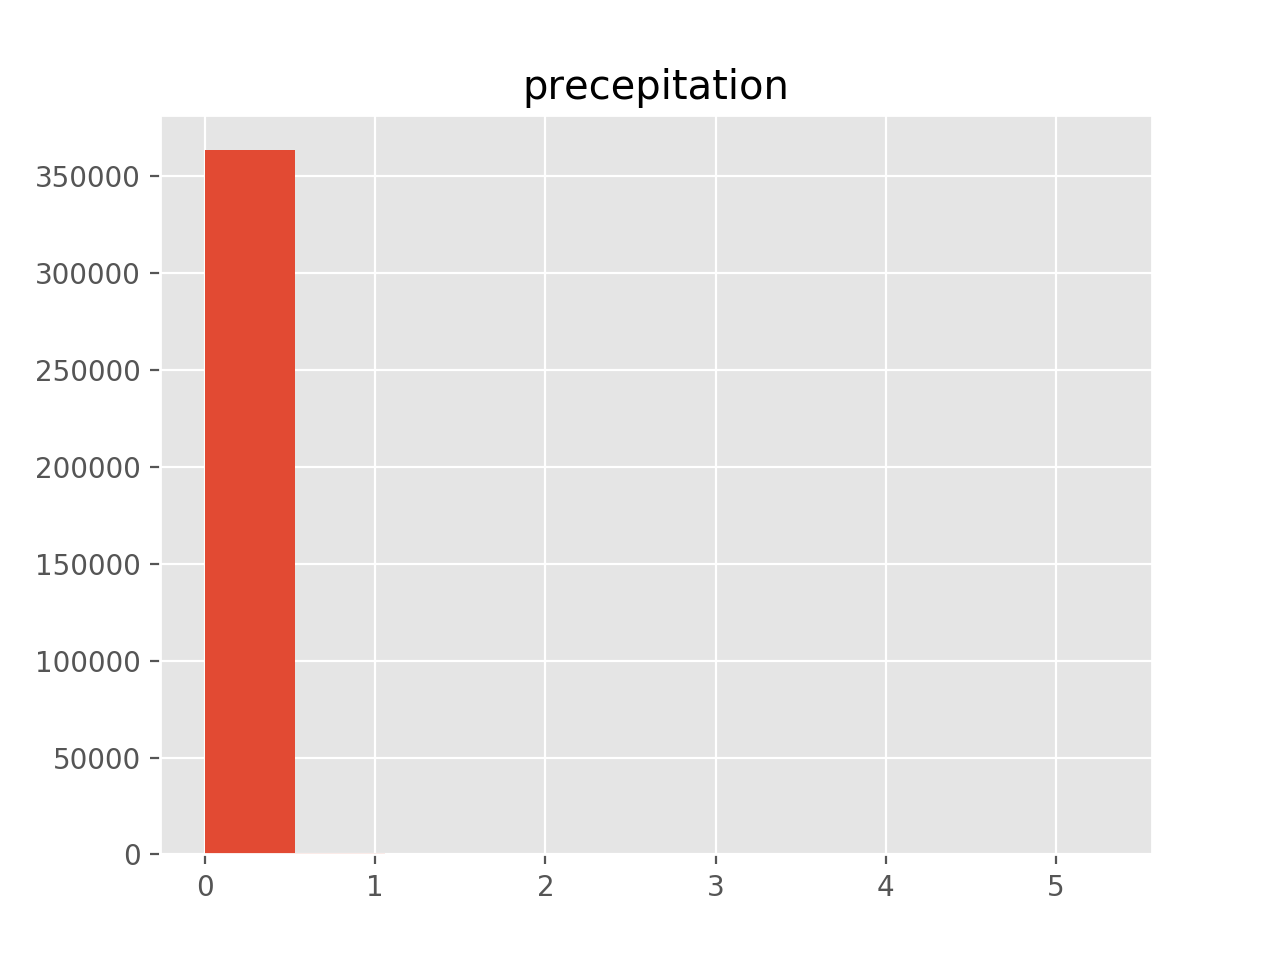

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x149167668>]], dtype=object)

In [48]:
rain_train.hist('precepitation')

The above does not look too promising. Let's investigate the data further:

In [49]:
values = set(rain_train.precepitation)
for rain in sorted(values):
    print(rain, np.sum(rain_train.precepitation == rain))
    
print(np.sum(rain_train.precepitation == 0) / rain_train.shape[0])

0.0 356685
0.2 3240
0.3 1992
0.4 908
0.5 495
0.6 263
0.7 185
0.8 107
0.9 58
1.0 46
1.1 27
1.2 24
1.3 8
1.4 5
1.5 7
1.6 3
1.7 2
1.8 2
1.9 2
2.0 2
2.5 2
2.6 2
2.7 1
2.8 1
3.1 1
3.6 1
3.8 1
4.5 1
5.3 1
0.979710057351


## My fears about binarization were premature (2)
Since the vast majority of timestamps have a rain value of 0, any model we train will be biased towards predicting 0, since it can receive an accuracy of almost 98% by just predicting false all the time.

This means I'll have to reach into the class imbalance arsenal - providing a substantial class weight for positives, oversampling them, or both. 

In [50]:
rain_train.precepitation = rain_train.precepitation > 0
rain_validation.precepitation = rain_validation.precepitation > 0
rain_test.precepitation = rain_test.precepitation > 0

In [51]:
DATE_FORMAT = '%Y%m%d'

for dataset in (rain_train, rain_validation, rain_test):
    dataset['LST_day_of_year'] = [datetime.strptime(str(lst_date), DATE_FORMAT).timetuple().tm_yday
                                  for lst_date in dataset.LST_date]

    dataset['LST_time_of_day'] = [lst_time if lst_time < 100 
                                  else int((lst_time % 100) + np.floor(lst_time / 100) * 60)
                                  for lst_time in dataset.LST_time]

## To normalize the non-basis functions, I use the standard scaler

In [57]:
DAY_MEANS = (0, 212, 365)
DAY_ALPHA = 70
TIME_MEANS = (0, 900, 1440)
TIME_ALPHA = 400

rain_data_mapper = DataFrameMapper([
    ('LST_day_of_year', RBFEncoder(DAY_MEANS, DAY_ALPHA)),
    ('LST_time_of_day', RBFEncoder(TIME_MEANS, TIME_ALPHA)),
    (['air_temperature'], sklearn.preprocessing.StandardScaler()),
    (['solar_radiation'], sklearn.preprocessing.StandardScaler()),
    (['relative_humidity'], sklearn.preprocessing.StandardScaler()),
    (['soil_moisture'], sklearn.preprocessing.StandardScaler()),
    (['wind'], sklearn.preprocessing.StandardScaler()),
])

transformed_train = rain_data_mapper.fit_transform(rain_train.copy())
print(transformed_train.shape)
transformed_train[:5]

(364072, 11)


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.01984109,  0.97421579,  0.05423723,  0.01662325,  0.82896435,
         0.76188997,  0.00435349, -1.37691301,  1.29419988, -1.37019052,
        -1.37676833],
       [ 0.01984109,  0.97421579,  0.05423723,  0.01603771,  0.82257756,
         0.76888605, -0.02128249, -1.37691301,  1.33398612, -1.37019052,
        -1.37676833],
       [ 0.01984109,  0.97421579,  0.05423723,  0.01547038,  0.81611245,
         0.77582514, -0.03410047, -1.37691301,  1.33398612, -1.37019052,
        -1.37676833],
       [ 0.01984109,  0.97421579,  0.05423723,  0.01492079,  0.80957165,
         0.78270454, -0.07255443, -1.37691301,  1.37377236, -1.37019052,
        -1.37676833],
       [ 0.01984109,  0.97421579,  0.05423723,  0.01438847,  0.8029578 ,
         0.78952157, -0.07255443, -1.37691301,  1.37377236, -1.37019052,
        -1.37676833]])

## Train a logistic regression model, cross-validating to select parameters
We perform a random search CV to pick the number of features to use, as well as the C (penalty) and positive class weight for the logistic regression model. The number of features is searched in a uniform distribution over integers, and C and the class weight are searched in log scale, so sampling uniformly and raising by the exponent.

Much of the code below is copied from my week 2 classification work

In [58]:
# report function from http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

np.random.seed(RANDOM_SEED)

logit_search_pipe = sklearn.pipeline.Pipeline([
    ('featurize', rain_data_mapper),
    ('select', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression)),
    ('logit', sklearn.linear_model.LogisticRegression(verbose=True))
])

from collections import namedtuple
ClassWeightSampler = namedtuple('ClassWeightSampler', 'rvs')
CSampler = namedtuple('CSampler', 'rvs')

def sample_class_weights(loc=0, scale=1, size=1, random_state=None):
    return {0: 1, 1: np.exp(uniform.rvs(loc=0, scale=4, size=size, random_state=random_state))[0]}


def log_sample_cv(loc=0, scale=1, size=1, random_state=None):
    return np.exp(uniform.rvs(loc=0, scale=4, size=size, random_state=random_state))[0]

class_weight_sampler = ClassWeightSampler(rvs=sample_class_weights)
c_sampler = CSampler(rvs=log_sample_cv)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    search_cv = RandomizedSearchCV(logit_search_pipe, n_iter=20, scoring='f1', n_jobs=4, 
                                   verbose=1, random_state=RANDOM_SEED,
                                   param_distributions={'select__k': randint(3, 10),
                                                        'logit__class_weight': class_weight_sampler,
                                                        'logit__C': c_sampler 
                                                       })
    search_cv.fit(X=rain_train, y=rain_train.precepitation)
    report(search_cv.cv_results_)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   32.7s finished


[LibLinear]Model with rank: 1
Mean validation score: 0.330 (std: 0.007)
Parameters: {'logit__C': 1.1352251554607866, 'logit__class_weight': {0: 1, 1: 6.6164003228231421}, 'select__k': 4}

Model with rank: 2
Mean validation score: 0.304 (std: 0.069)
Parameters: {'logit__C': 47.470443699444594, 'logit__class_weight': {0: 1, 1: 4.8239589819997821}, 'select__k': 9}

Model with rank: 3
Mean validation score: 0.292 (std: 0.064)
Parameters: {'logit__C': 1.7791227391283269, 'logit__class_weight': {0: 1, 1: 6.697476494418094}, 'select__k': 9}



In [62]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, mutual_info_score

validation_predictions = search_cv.best_estimator_.predict(rain_validation)

for metric in (classification_report, accuracy_score, roc_auc_score, mutual_info_score):
    print(metric.__name__)
    print(metric(validation_predictions, rain_validation.precepitation))


classification_report
             precision    recall  f1-score   support

      False       0.95      0.99      0.97     98320
       True       0.76      0.23      0.36      6743

avg / total       0.94      0.95      0.93    105063

accuracy_score
0.946137079657
roc_auc_score
0.614912421006
mutual_info_score
0.0325303236467


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


The results look reasonable - the recall for true examples is still terrible, but on the balance it appears reasonable. The validation f1 score is better than on the training set, which is solid.

In [125]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, mutual_info_score

test_predictions = search_cv.best_estimator_.predict(rain_test)

for metric in (classification_report, accuracy_score, roc_auc_score, mutual_info_score):
    print(metric.__name__)
    print(metric(test_predictions, rain_test.precepitation))


classification_report
             precision    recall  f1-score   support

      False       0.93      0.99      0.96     95646
       True       0.79      0.28      0.41      9728

avg / total       0.92      0.93      0.91    105374

accuracy_score
0.92624366542
roc_auc_score
0.634054261613
mutual_info_score
0.0479381663107


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
